**POPPY RL PROJET - video capturing and preprocessing**
---
IA705 Apprentissage pour la robotique - Mai et Damien

Groupe : Anaële Baudant-Cojan, Edouard et Pierre

## Install **mediapipe** : algorithm for human pose estimation from video <br>(pre-trained "Blazepose" model) :

- the article describing the algorithm is in https://arxiv.org/abs/2006.10204
- the source code is still available at https://github.com/google/mediapipe

In [1]:
#!pip install mediapipe

In [1]:
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# libraries provided by the authors
from utils.blazepose import blazepose_skeletons
from utils.skeleton import forward_kinematics, find_quaternions, pyplot_skeleton, reorient_skeleton, set_axes_equal
from utils.quaternion import batch_quat_left_multiply, batch_quat_inverse

# from mpl_toolkits.mplot3d import Axes3D
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# from pypot.creatures import PoppyTorso
# from pypot.creatures.ik import IKChain
# from pypot.primitive.move import Move
# from pypot.primitive.move import MovePlayer


**0/ Functions used in the notebook**
---

In [2]:
########################################################
# FUNCTIONS FOR VIDEO CAPTURE & SKELETON PREPROCESSING #
########################################################

import cv2

# CHECK ACCESS TO CAMERA
#--------------------------

def check_camera(i=0):
    '''function will check if the camera number i (0 by default) is available and openable
    and show the first frame captured from the camera
    '''
    # Open a connection to the cameras N°0
    print("opening camera...", time.strftime("%H:%M:%S", time.localtime()))
    cap1 = cv2.VideoCapture(0)


    # Capture 1 frame
    if not cap1.isOpened():
        print("Error: Camera could not be opened.", time.strftime("%H:%M:%S", time.localtime()))
    else:
        print("Camera is open and capturing.", time.strftime("%H:%M:%S", time.localtime()))

        # Try to get a frame to check if we can actually capture
        ret, frame = cap1.read()  # ret is a boolean (for return) that returns true if the frame is available.
        
        if ret:
            print("Frame captured successfully. Press a key to close frame window")
            print("Frame shape and type", frame.shape, frame.dtype)
            # Display the captured frame
            cv2.namedWindow('Captured Frame - press key to close', cv2.WINDOW_NORMAL) 
            cv2.imshow('Captured Frame - press key to close frame', frame)
            # cv2.waitKey(0)  # Wait for a key press to close the displayed window
            # cv2.destroyAllWindows()
        else:
            print("Failed to capture frame.")

def take_video(cap, filename='output.avi', path='./resources/', duration=5, fps=30, delay = 0):  
    """
    Captures a video from the camera and saves it to a file.

    Parameters:
    - cap : ongoing camera (must have been launched by cap = cv2.VideoCapture(0)).
    - filename (str): The name of the video file to save. Default is 'output.avi'.
    - path (str): The directory path where the video file will be saved. Default is './resources/'.
    - duration (int): The duration of the video in seconds. Default is 5.
    - fps (int): The frames per second of the video. Default is 30.
    - delay (int): Delay before starting the recording in seconds. Default is 0.
    """
    # Open a connection to the camera
    # cap = cv2.VideoCapture(camera)

    if not cap.isOpened():
        print("Error: Camera is not opened. Use cap = cv2.VideoCapture(0) to open")
    else:
                
        # Define the codec 
        fourcc = cv2.VideoWriter_fourcc(*'H264')  # Four-Character Code to specify the codec
            # .avi => 'XVID'
            # .mov => 'H264' high quality compression (or 'MJPG' quicker but poorer compression or 'AVID' professional codec)
            # .mp4 => 'H264' or 'X264' high quality compreesion (or 'XVID' or 'MP4V' large compatibility)
        # create a VideoWriter object
        out = cv2.VideoWriter(path + filename, fourcc, fps, (640, 480))

        # Delay the start of the video
        if delay > 0 : print(f"Camera will start recording in {delay} seconds")
        time.sleep(delay)

        # Record the video
        print("Camera is open and capturing.")
        start_time = time.time()
        
        while (time.time() - start_time) < duration:
            ret, frame = cap.read()
            if ret:
                # Write the frame to the output video file
                out.write(frame)
                # Display the frame
                cv2.imshow('frame', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
    
        # Release everything when done
        out.release()
        cv2.destroyAllWindows()
        print("Video captured and saved successfully.")


def get_video_details(file):
    """
    Retrieves and prints the frames per second (FPS), total number of frames,
    and duration of a video file.

    Parameters:
    - file (str): The name of the video file with the directory path and extension.
    """

    capture = cv2.VideoCapture(file)

    if not capture.isOpened():
        print("Error opening video file:", file)
    
    else:
        ret, frame = capture.read()
        fps = capture.get(cv2.CAP_PROP_FPS)                     # Get frames per second (fps)
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))   # Get total number of frames in the video
        if fps > 0: duration = total_frames / fps               # Calculate the duration of the video

        print(f"Video: {file} ")
        print(f"Frames per Second: {fps}")
        print(f"Total number of frames: {total_frames}")
        print(f"Duration of video in seconds: {duration}")
        print(f"Image dimensions: {frame.shape}")
    
    # Release the video capture object
    capture.release()
    
# PREPROCESSING OF SKELETONS 
# reorder axes, center, rotate, smooth, interpolate
#---------------------------------------------------

def reorder_axes(skeletons):
    '''function preprocesses skeletons by giving it coordinates (x,y,z) instead of (x,z,-y)
    indeed the blazepose_skeletons function returns skeletons in (x,z,-y) format (-y for selfie mode)'''
    
    reordered_skeletons = skeletons.clone()
    reordered_skeletons[:, :, 2] = -skeletons[:, :, 1] # change y to -z
    reordered_skeletons[:, :, 1] = skeletons[:, :, 2] # change z to y
    return reordered_skeletons

def center_skeletons(skeletons, ref_joint=0):
    '''function preprocesses skeletons by giving it coordinates (x,y,z) instead of (x,z,y) 
    and centering coordinates on choosen joint (by default reference joint is 0 (pelvis)'''
    
    rota_skeletons = skeletons.clone()
    # creates a vector size [n_frames, 1, 3] with the choosen center's postions at each frame
    center = rota_skeletons[:, ref_joint, :].unsqueeze(1) # image will be centered on each frame with the reference joint 
    center = center.repeat(1, skeletons.shape[1], 1) # repeat the center position 17 times (to match the number of joints)
    centered_skeletons = rota_skeletons - center
    return centered_skeletons


def rotate_skeletons(skeletons, alpha, topology):

    ''' function rotates skeletons coordinates (x,y,z) by alpha around the z-axis.
    The function transforms x,y,z coordinates to quarternions to implement rotation and then
    transforms back to x,y,z coordinates using forward kinematics library
    to understand quarternions, see https://eater.net/quaternions/video/intro for interactive explanation
    !!! Note function centers the skeleton on the pelvis due to the rotation process !!!
    Inputs :
    - skeletons (torch tensor [n_frames, n_joints, 3]) : skeletons in (x,y,z) format
    - alpha (float) : angle of rotation in radians (Pi/2 for 90° for example)
    - topology : list with the connections between joints (child-parent relations)
    and returns skeletons in quaternions format
    
    Output : skeletons in (x,y,z) coordinates
    '''

    # preprocess skeletons
    rota_skeletons_A = skeletons.clone()
    n_frames, n_joints, _ = rota_skeletons_A.shape # batch size is the number of frames

    # Measure skeleton bone lengths
    lengths = torch.Tensor(n_frames, n_joints)
    for child, parent in enumerate(topology):   # child = value and parent = index
            lengths[:, child] = torch.sqrt(
                torch.sum(
                    (rota_skeletons_A[:, child] - rota_skeletons_A[:, parent])**2,
                    axis=-1
                )
            )

    # Find the corresponding angles
    offsets = torch.zeros(n_frames, n_joints, 3)
    offsets[:, :, -1] = lengths
    quaternions = find_quaternions(topology, offsets, rota_skeletons_A)

    # Rotate of alpha
    #define the rotation by its quaternion
    rotation = torch.Tensor([np.cos(alpha/2),  np.sin(alpha/2),0,0]).unsqueeze(0).repeat(n_frames*n_joints, 1)
    quaternions = quaternions.reshape(n_frames*n_joints, 4)
    quaternions = batch_quat_left_multiply(
            batch_quat_inverse(rotation),
            quaternions
        )
    quaternions = quaternions.reshape(n_frames, n_joints, 4)

    # Use these quaternions in the forward kinematics to go back to skeleton
    skeleton = forward_kinematics(
            topology,
            torch.zeros(n_frames, 3),
            offsets,
            quaternions
        )[0]

    outputs= skeleton.clone()

    return outputs

def moving_average(a, n=3) :
    '''function computes the moving average of a tensor a along the first dimension (n_frames)'''
    repeat_shape = list(a.shape)
    repeat_shape[1:] = [1 for _ in range(len(repeat_shape)-1)]
    repeat_shape[0] = n//2
    a = torch.cat([a[:1].repeat(*repeat_shape), a, a[-2:].repeat(*repeat_shape)])
    ret = torch.cumsum(a, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smoothen_skeleton_mooving(skeleton, n=3):
    '''
    Smoothens a skeletons coordinates with a mooving average.
    Returns the new skeleton with an adjusted number of frames (initial number of frames - n + 1).
        with n=1, it does nothing
        With n=2, it returns mooving average of 2 frames (arithmetic average)
        With n=3, it returns mooving average of 3 frames
    Number of joints and the (x,y,z) coordinates are unchanged
    '''

    length, joints, _ = skeleton.shape

    smoothed_skeletons = torch.zeros(length - n + 1, joints, 3)

    for i in range(length - n + 1):
        # Extract the frames for moving average
        frames_to_average = skeleton[i:i+n,:,:]
        # Compute the moving average for these frames
        smoothed_frame = moving_average(frames_to_average, n)
        # Take the last frame of the moving average as the smoothed frame
        smoothed_skeletons[i,:,:] = smoothed_frame[-1,:,:]

    return smoothed_skeletons

def interpolate_skeletons(skeletons, factor=1):
    '''
    Interpolates the targets by a factor of `factor` between each pair of values between frames.
    Returns the new skeleton with an adjusted number of frames (initial number of frames * factor).
        with factor=1, it does nothing
        With factor=2, it doubles the number of frames (keypoints)
        With factor=0.5, it divides the number of frames (keypoints)
    Number of joints and the (x,y,z) coordinates are unchanged
    '''

    length, joints, _ = skeletons.shape

    new_skeletons = torch.zeros((length-1) * factor + 1, joints, 3)

    for i in range(new_skeletons.shape[0]):

        skeletons_id = float(i/factor)
        before_id = int(np.floor(skeletons_id))
        after_id = int(np.floor(skeletons_id + 1))

        before_coef = 1 - (skeletons_id - before_id)
        after_coef = 1 - (after_id - skeletons_id)

        if after_id > length - 1:
            after_id = length - 1

        new_skeletons[i] = before_coef * skeletons[before_id] + after_coef * skeletons[after_id]

    return new_skeletons

def preprocess_skeletons(skeletons, topology, ref_joint = 0 , alpha= np.pi/4*3 , smoothing_n=4, interpolation_factor = 1 ):
    '''
    Function to process skeletons from video to poppy format skeletons
    '''
    preprocessed_skeletons = reorder_axes(skeletons)
    preprocessed_skeletons = rotate_skeletons(preprocessed_skeletons, alpha, topology)
    preprocessed_skeletons = center_skeletons(preprocessed_skeletons, ref_joint=ref_joint)
    preprocessed_skeletons = smoothen_skeleton_mooving(preprocessed_skeletons, n=smoothing_n)
    preprocessed_skeletons = interpolate_skeletons(preprocessed_skeletons, factor=interpolation_factor)

    return preprocessed_skeletons

# PLOT SKELETON AND PLAY VIDEO OF SKELETON
#--------------------------------------------

def plot_skeletons_xyz(skeletons, topology, frame=0,proportionnal= 0, title=''):
    '''Displays a skeleton in 3D using the (x, y, z) coordinates of its joints
    at frame number 'frame' from the skeletons tensor. To keep image proportionnal
    set proportionnal to 1. Default is 0.
    '''

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot connections between joints
    for child, parent in enumerate(topology):
        if parent != -1:  # Ensure there is a valid parent joint
            ax.plot([skeletons[frame, parent, 0], skeletons[frame, child, 0]],
                    [skeletons[frame, parent, 1], skeletons[frame, child, 1]],
                    [skeletons[frame, parent, 2], skeletons[frame, child, 2]], 'ro-')
    
    # Plot points (joints)
    ax.scatter(skeletons[frame, :, 0], skeletons[frame, :, 1], skeletons[frame, :, 2], c='r', marker='.', s=1)
    
    # Proportionnal display
    if proportionnal != 0:
        max_value = skeletons.max(axis=2).values.numpy()
        min_value = skeletons.min(axis=2).values.numpy()
        limit = np.max([max_value, -min_value])
        ax.set_xlim([-limit, limit])
        ax.set_ylim([-limit, limit])
        ax.set_zlim([-limit, limit])

    # Set plot title and labels
    ax.set_title(title+'Skeleton in 3D (from (x, y, z) coordinates)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

def plot_skeletons_video_xyz(skeletons, topology, proportionnal= 0, title=''):
    '''Displays a video of a skeleton in 3D using the (x, y, z) coordinates of its joints'''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Setup the plot limits only once based on the provided flag
    if proportionnal != 0:
        max_value = skeletons.max(axis=2).values.numpy()
        min_value = skeletons.min(axis=2).values.numpy()
        limit = np.max([max_value, -min_value])
        ax.set_xlim([-limit, limit])
        ax.set_ylim([-limit, limit])
        ax.set_zlim([-limit, limit])

    ax.set_title(title+'Skeleton in 3D (from (x, y, z) coordinates)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Pre-create line objects for each joint connection
    lines = [ax.plot([], [], [], 'ro-')[0] for _ in topology if _ != -1]

    # Plot the skeleton
    for frame in range(skeletons.shape[0]):
        line_idx = 0  # Index for lines array
        for child, parent in enumerate(topology):
            if parent != -1:  # Ensure there is a valid parent joint
                lines[line_idx].set_data([skeletons[frame, parent, 0], skeletons[frame, child, 0]],
                                         [skeletons[frame, parent, 1], skeletons[frame, child, 1]])
                lines[line_idx].set_3d_properties([skeletons[frame, parent, 2], skeletons[frame, child, 2]])
                line_idx += 1

        # Manage display updates
        clear_output(wait=True)  # Clear the output to update the plot
        display(fig)  # Display the current frame
        plt.pause(0.005)  # Short pause for animation effect

    plt.close(fig)  # Close the plot after the animation

import matplotlib.pyplot as plt
import torch

def plot_3d_hand_trajectory(targets, period=20, title='Targets -'):
    """
    Plot 3D trajectories from a tensor and annotate specific points.
    
    Parameters:
    - targets (torch.Tensor): A tensor with shape [N, 2, 3] where N is the number of time steps.
    - period (int): The interval at which to place annotations and markers.
    """
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extracting the coordinates for both lines
    x1, y1, z1 = targets[:, 0, 0], targets[:, 0, 1], targets[:, 0, 2]
    x2, y2, z2 = targets[:, 1, 0], targets[:, 1, 1], targets[:, 1, 2]
    
    # Plotting line 1
    ax.plot(x1.numpy(), y1.numpy(), z1.numpy(), label='Line 1')
    
    # Plotting line 2
    ax.plot(x2.numpy(), y2.numpy(), z2.numpy(), label='Line 2')
    
    # Plot a dot every 'period' frames, annotate them, and adjust dot size and text position
    for t in range(0, len(targets), period):
        ax.scatter(x1[t].numpy(), y1[t].numpy(), z1[t].numpy(), color='black', s=10)  # Smaller dot size
        ax.scatter(x2[t].numpy(), y2[t].numpy(), z2[t].numpy(), color='black', s=10)  # Smaller dot size
        ax.text(x1[t].numpy() + 0.02, y1[t].numpy(), z1[t].numpy(), t, color='black', ha='left',fontsize=6)
        ax.text(x2[t].numpy() + 0.02, y2[t].numpy(), z2[t].numpy(), t, color='black', ha='left',fontsize=6)
    
    # Labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(title + '3D Line Plot of Targets with Time Steps')
    
    # Show the plot
    plt.show()

# TRANSPOSE TO POPPY'S SKELETTON
#--------------------------------

def get_poppy_skeletons(skeletons, topology, poppy_lengths):
    # Works in batched
    n_frames, n_joints, _ = skeletons.shape

    # Measure skeleton bone lengths
    source_lengths = torch.Tensor(n_frames, n_joints)
    for child, parent in enumerate(topology):
        source_lengths[:, child] = torch.sqrt(
            torch.sum(
                (skeletons[:, child] - skeletons[:, parent])**2,
                axis=-1
            )
        )

    # Find the corresponding angles
    source_offsets = torch.zeros(n_frames, n_joints, 3)
    source_offsets[:, :, -1] = source_lengths
    quaternions = find_quaternions(topology, source_offsets, skeletons)

    # Re-orient according to the pelvis->chest orientation
    base_orientation = quaternions[:, 7:8].repeat(1, n_joints, 1).reshape(n_frames*n_joints, 4)
    base_orientation += 1e-3 * torch.randn_like(base_orientation)
    quaternions = quaternions.reshape(n_frames*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(base_orientation),
        quaternions
    )
    quaternions = quaternions.reshape(n_frames, n_joints, 4)

    # Use these quaternions in the forward kinematics with the Poppy skeleton
    target_offsets = torch.zeros(n_frames, n_joints, 3)
    target_offsets[:, :, -1] = poppy_lengths.unsqueeze(0).repeat(n_frames, 1)
    target_positions = forward_kinematics(
        topology,
        torch.zeros(n_frames, 3),
        target_offsets,
        quaternions
    )[0]

    # Measure the hip orientation
    alpha = np.arctan2(
        target_positions[0, 1, 1] - target_positions[0, 0, 1],
        target_positions[0, 1, 0] - target_positions[0, 0, 0]
    )

    # Rotate by alpha around z
    alpha = alpha
    rotation = torch.Tensor([np.cos(alpha/2), 0, 0, np.sin(alpha/2)]).unsqueeze(0).repeat(n_frames*n_joints, 1)
    quaternions = quaternions.reshape(n_frames*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(rotation),
        quaternions
    )
    quaternions = quaternions.reshape(n_frames, n_joints, 4)

    # Use these quaternions in the forward kinematics with the Poppy skeleton
    poppy_skeletons = forward_kinematics(
        topology,
        torch.zeros(n_frames, 3),
        target_offsets,
        quaternions
    )[0]


    return poppy_skeletons





**1/ Capture a video and get poppy skeleton**
---
See section 2 for detailed preprocessing step by step and explanations<br>
Go to section 3 to generate multiple training examples

In [3]:
# CHECK YOUYR CAMERA IS WORKING
# !!! press a key to close frame window and continue !!!

check_camera(0)



opening camera... 22:46:39
Camera is open and capturing. 22:47:15
Frame captured successfully. Press a key to close frame window
Frame shape and type (480, 640, 3) uint8


In [4]:
# CAPTURE A 10 SECOND VIDEO

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!  starts with arms appart from body    !!!
# !!!  for good skeleton extraction         !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# open camera (only if necessary to gain opening time)
try:
    if not cap.isOpened():
        cap = cv2.VideoCapture(0)
except NameError:
    cap = cv2.VideoCapture(0)

# choose parameters
duration = 10    # length of video
delay = 3       # time before video starts
fps = 30        # frame per second
path = './resources/'  # path to save video
format = 'mp4'  # format of video
filename = 'output' + '.' + format

# Capture video (unquote)
take_video(cap, filename=filename, path=path, duration=duration, fps=fps, delay=delay)

print("\nVideo details")
get_video_details(path + filename)

# close camera
# cap.release()



Camera will start recording in 3 seconds
Camera is open and capturing.
Video captured and saved successfully.

Video details
Video: ./resources/anaele_kneel_down.mp4 
Frames per Second: 30.0
Total number of frames: 275
Duration of video in seconds: 9.166666666666666
Image dimensions: (480, 640, 3)


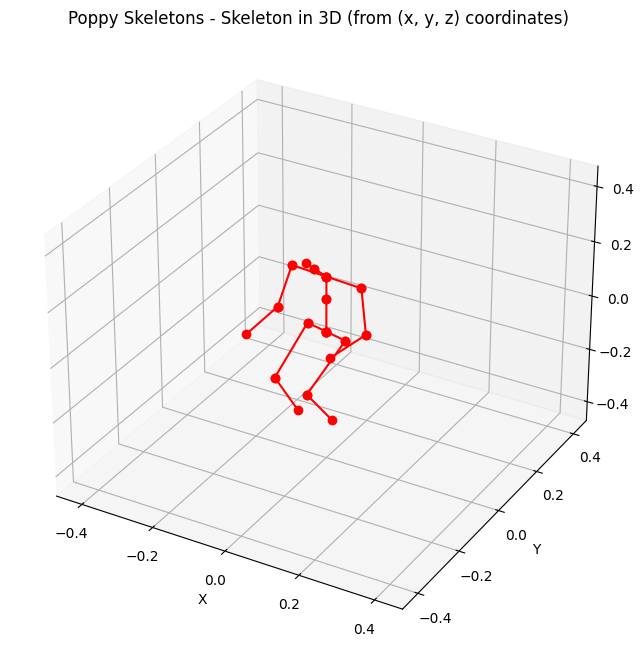

In [5]:
# GET POPPY SKELETONS

# Choose video file
path = './resources/'
# file = 'mai1.mov'
# file = 'anaele_twist.mp4' # anaele_kneel_down.mp4  anaele_twist.mp4 anaele_hoola_hoop.mp4
file = 'output.mp4'
video = path + file

# Extract humain skeleton from video and preprocess
skeletons = blazepose_skeletons(video)
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15] # connections between joints (see bellow)
skeletons_pp = preprocess_skeletons(skeletons, topology, alpha= np.pi/4 , smoothing_n=4, interpolation_factor = 1 )
torch.save(skeletons_pp, path + file[:-4] + '_skeletons.pt')
plot_skeletons_video_xyz(skeletons_pp, topology, proportionnal=1, title='Preprocessed HUMAN Skeletons - ')

# Get Poppy target skeleton from human skeleton
poppy_lengths = torch.Tensor([0.0, 0.07, 0.18, 0.19, 0.07, 0.18, 0.19, 0.12, 0.08, 0.07, 0.05, 0.1, 0.15, 0.13, 0.1, 0.15, 0.13])
poppy_skeletons = get_poppy_skeletons(skeletons, topology, poppy_lengths)
torch.save(poppy_skeletons, path + file[:-4] + '_poppy_skeletons.pt')

# show poppy skeletons (target moovements)
plot_skeletons_video_xyz(poppy_skeletons, topology, proportionnal=1, title='Poppy Skeletons - ')

**2/ Detailed pre-processing**
---

1. Extract skeleton
2. Center & Rotate skeleton
3. smoothen skeleton (and interpolated frames if necessary - video too quick)
4. Transfer skeleton positions to poppy skeleton dimensions<br>
(5. Selection targets - hands or all arms joints) - Optionnal


skeleton's shape [n_frames, n_joints, dimensions]: torch.Size([151, 17, 3])


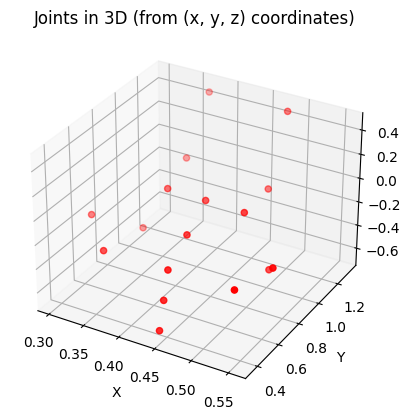

In [6]:
# 1/ Extract skeleton (joints) and show joints
#--------------------------------------------

path = './resources/anaele/'
file = 'anaele_0.mov' # is shorter !
video = path + file

skeletons = blazepose_skeletons(video)             # will play video
print("\nskeleton's shape [n_frames, n_joints, dimensions]:", skeletons.shape)

# The skeletons variable is a tensor of size : [279, 17, 3]
# - 279 = the number of frames in the video :
# -  17 = joints in the human figure model
# -   3 = for the (x,y,z) positions

# show joints position from frame 0
frame = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(skeletons[frame, :, 0], skeletons[frame, :, 1], skeletons[frame, :, 2], c='r', marker='o')
ax.set_title('Joints in 3D (from (x, y, z) coordinates)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

child joint:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
parent joint: [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]

The connections between the joints are:
Child joint 0 (Pelvis) is connected to parent joint 0 (Pelvis)
Child joint 1 (Left hip) is connected to parent joint 0 (Pelvis)
Child joint 2 (Left knee) is connected to parent joint 1 (Left hip)
Child joint 3 (Left ankle) is connected to parent joint 2 (Left knee)
Child joint 4 (Right hip) is connected to parent joint 0 (Pelvis)
Child joint 5 (Right knee) is connected to parent joint 4 (Right hip)
Child joint 6 (Right ankle) is connected to parent joint 5 (Right knee)
Child joint 7 (Spine) is connected to parent joint 0 (Pelvis)
Child joint 8 (Chest) is connected to parent joint 7 (Spine)
Child joint 9 (Neck) is connected to parent joint 8 (Chest)
Child joint 10 (Head) is connected to parent joint 9 (Neck)
Child joint 11 (Left shoulder) is connected to parent joint 8 (Chest)
Child joint 12 (Left elbow) i

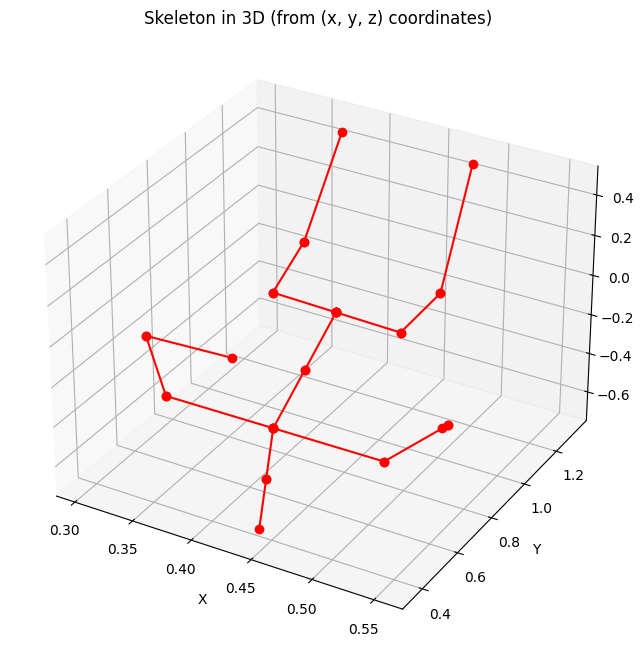

In [7]:
# USING TOPOLOGY TO BETTER PLOT THE SKELETON (17 JOINTS)
#-------------------------------------------------------

# Skeleton topology (child-parent relationship between joints)
# index of topology is the child joint and the value is the parent joint (to which child joint is linked)
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]
print("child joint: ",list(range(0,len(topology))))
print("parent joint:",topology[0:])

# The 17 joints name are:
joints_name = ['Pelvis', 'Left hip', 'Left knee', 'Left ankle', 'Right hip', 'Right knee', 'Right ankle', 'Spine', 'Chest', 'Neck', 'Head', 'Left shoulder', 'Left elbow', 'Left wrist', 'Right shoulder', 'Right elbow', 'Right wrist']

# Print the connections between the joints
print("\nThe connections between the joints are:")
for child, parent in enumerate(topology): 
    print(f"Child joint {child} ({joints_name[child]}) is connected to parent joint {parent} ({joints_name[parent]})")

plot_skeletons_xyz(skeletons, topology, frame=0)

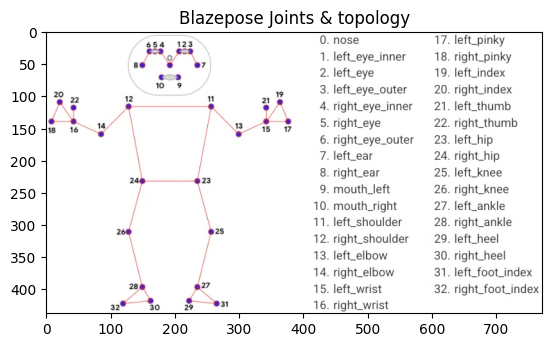

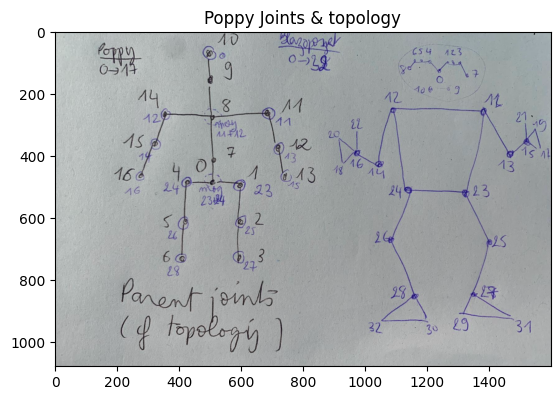

In [8]:
# JOINTS NAME (AS IN BLAZEPOSE)
# values with a  "*" are interpolated from Blazepose keypoints (and ->" will indicate they are computed)

# 0 * Pelvis (root) -> average between hips (1 and 4)
# 1 - Left hip
# 2 - Left knee
# 3 - Left ankle
# 4 - Right hip
# 5 - Right knee
# 6 - Right ankle
# 7 * Chest         -> average between pelvis and neck (0 and 8)
# 8 * Base of neck  -> average between shoulders (11 and 14)
# 9 * Base of head  -> average between top of head and base on neck (10 and 8)
# 10 - Head (center)-> nose in Blasepose
# 11 - Left shoulder
# 12 - Left elbow
# 13 - Left wrist
# 14 - Right shoulder
# 15 - Right elbow
# 16 - Right wrist

#show the skeleton in 3D from blazepose_madiapipe_joints.webp
blazepose_joints= cv2.imread('./blazepose_mediapipe_joints.webp')
plt.imshow(blazepose_joints)
plt.title('Blazepose Joints & topology')
plt.show()
poppy_joints= cv2.imread('./poppy_joints_topology.jpg')
plt.imshow(poppy_joints)
plt.title ('Poppy Joints & topology' )
plt.show()

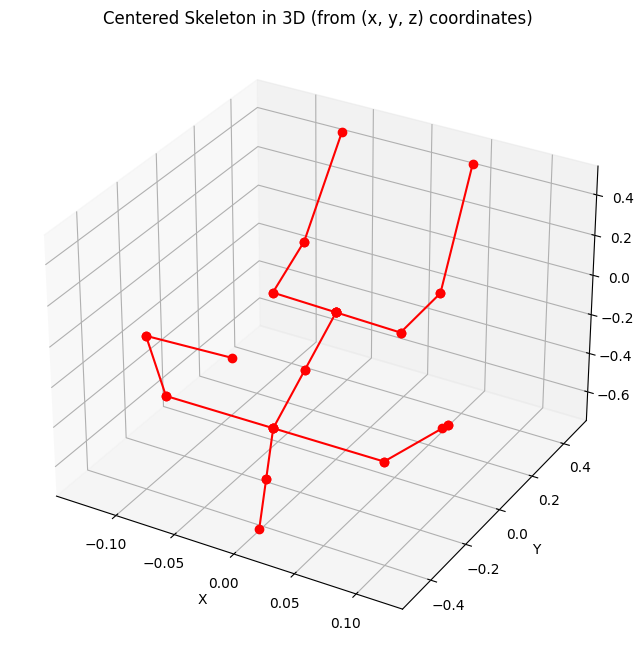

skeletons shape torch.Size([151, 17, 3])


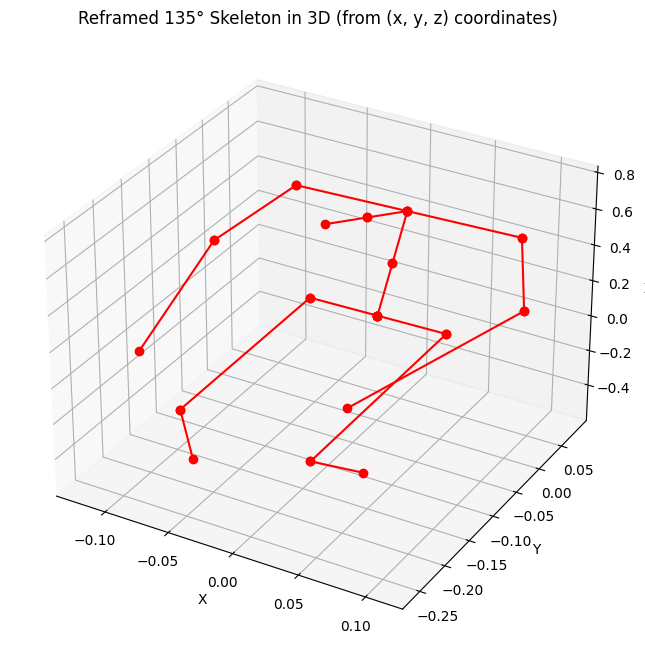

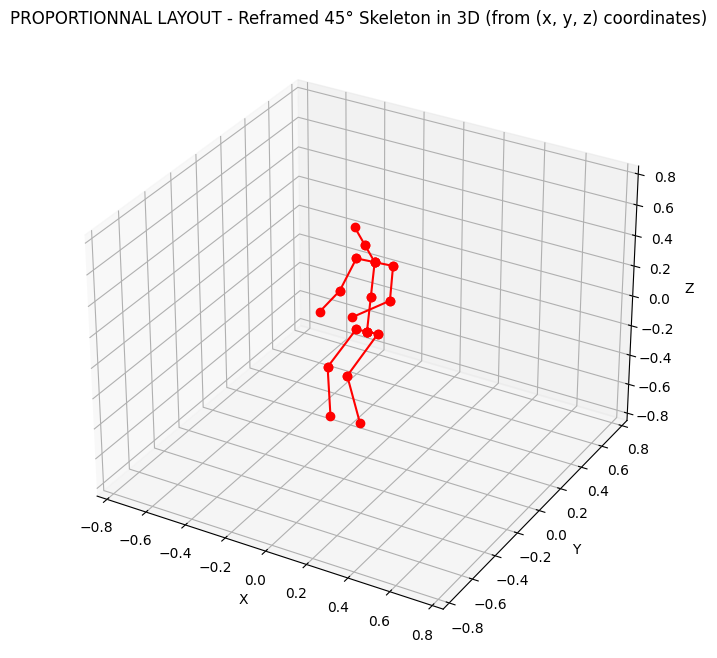

In [9]:
# 2/ NORMALIZE (CENTER & ROTATE) SKELETONS
#---------------------------------------
#!!! need to have proportional layout to avoid distrosions !!!
# proportionnal layout means x, y and z axis have the same limits [-0.6,0.6] bellow

# Preprocess the skeletons (center and get x,y,z coordinates)
skeletons_pp = center_skeletons(skeletons, ref_joint=0)
plot_skeletons_xyz(skeletons_pp, topology, frame=0, title='Centered ')

# change frame (rotate)
# define rotation angle to 45° (Pi/4) for Mai/output video
# define rotation angle to 135° (3*Pi/4) for Anaele videos
alpha = np.pi/4.*3.
skeletons_reframed = rotate_skeletons(skeletons, alpha, topology)

# save to file
torch.save(skeletons_reframed, path + file +'skeletons_reframed.pt')

print("skeletons shape", skeletons_reframed.shape)
plot_skeletons_xyz(skeletons_reframed, topology, frame=10, title='Reframed 135° ')
plot_skeletons_xyz(skeletons_reframed, topology, frame=10, proportionnal=1,  title='PROPORTIONNAL LAYOUT - Reframed 135° ')


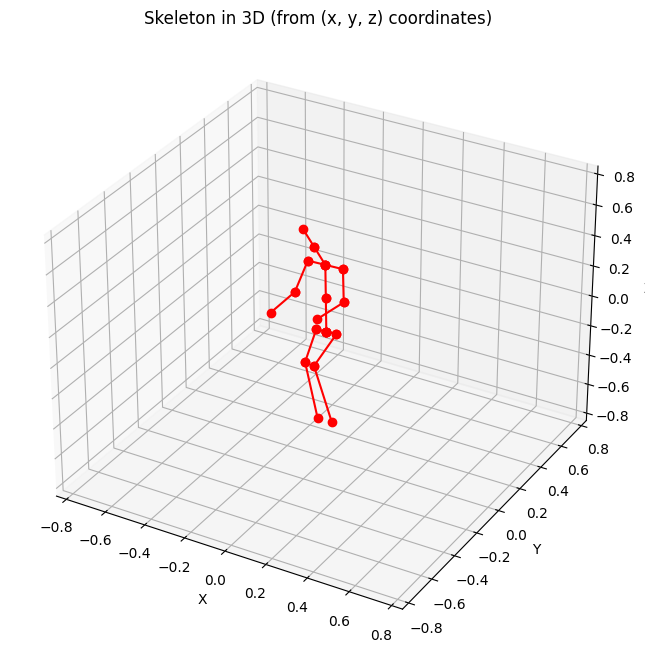

In [10]:
# CHECK "VIDEO" OF SKELETONS

plot_skeletons_video_xyz(skeletons_reframed, topology, proportionnal=1)

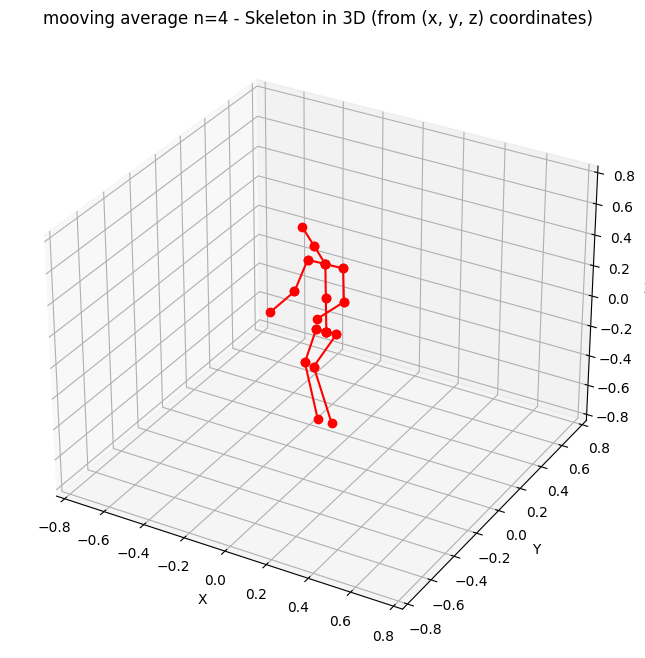

In [11]:
# 3/ SMOOTHEN SKELETONS AND PLOT VIDEO
#---------------------------------------

# arithmetic average between 2 frames (n=2  )
smoothed_skeletons_2 = smoothen_skeleton_mooving(skeletons_reframed, n=2)
plot_skeletons_video_xyz(smoothed_skeletons_2, topology, proportionnal=1, title = "mooving average n=2 - ") 

# mooving average between 4 frames (n=4)
smoothed_skeletons_4 = smoothen_skeleton_mooving(skeletons_reframed, n=4)
plot_skeletons_video_xyz(smoothed_skeletons_4, topology, proportionnal=1, title = "mooving average n=4 - ")

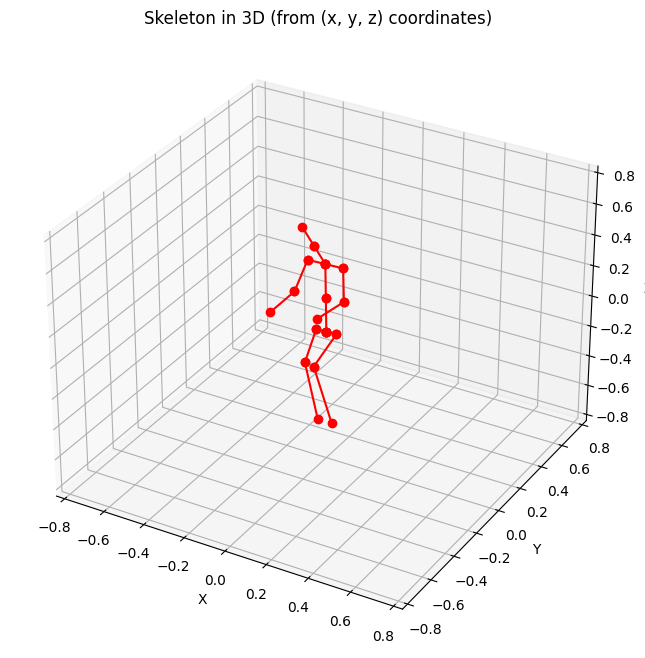

In [12]:
# INTERPOLATE IF MOOVEMENT IS TOO QUICK

interpolated_skeletons = interpolate_skeletons(smoothed_skeletons_4, factor=2) # factor 2 will slow down the moovements
plot_skeletons_video_xyz(interpolated_skeletons, topology, proportionnal=1)


In [13]:
# 4/ CONVERT TO POPPY SKELETON DIMENSIONS
#---------------------------------------

poppy_lengths = torch.Tensor([
    0.0,
    0.07,
    0.18,
    0.19,
    0.07,
    0.18,
    0.19,
    0.12,
    0.08,
    0.07,
    0.05,
    0.1,
    0.15,
    0.13,
    0.1,
    0.15,
    0.13
])

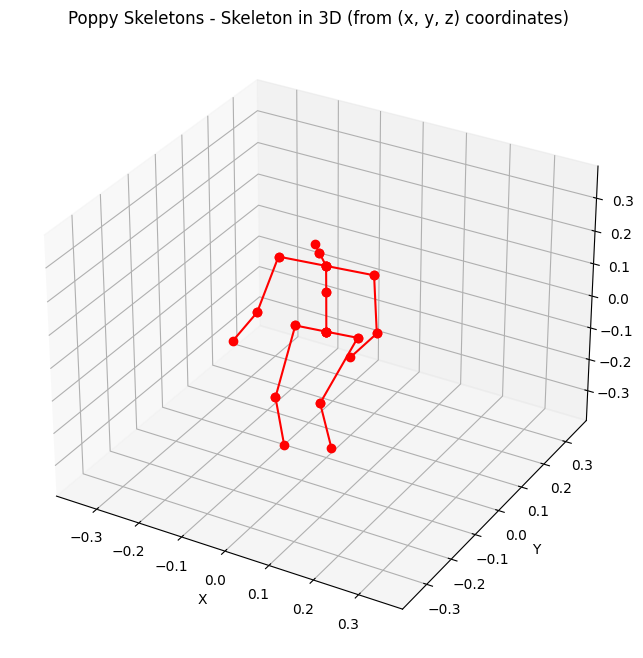

In [14]:
# get poppy's skeleton and save it
poppy_skeletons = get_poppy_skeletons(smoothed_skeletons_4, topology, poppy_lengths)
plot_skeletons_xyz(poppy_skeletons, topology, frame=10, proportionnal=1, title='Poppy ')
torch.save(poppy_skeletons, path + file[:-4] +'poppy_skeletons.pt')

plot_skeletons_video_xyz(poppy_skeletons, topology, proportionnal=1, title='Poppy Skeletons - ')

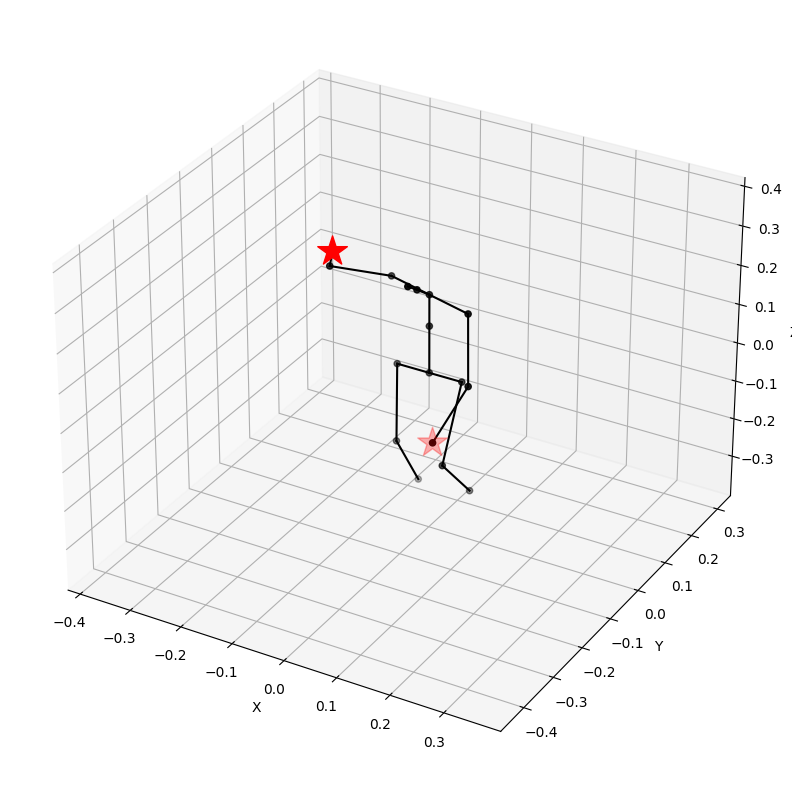

In [15]:
# 5/ EXTRACTION OF TARGET POSITIONS FOR THE TORSO AND THE END-EFFECTOR (hands)
#-----------------------------------------------------------------------------

# Return only target positions for the end-effector of the 6 kinematic chains (shoulder, elbow and hand x 2):
torso_indices = [0, 7, 8, 9,10, 13, 12, 11, 16, 15,14]
# Pelvis, Bust, Chest, neck, head, left hand, left elbow, left shoulder, right hand, right elbow, right shoulder
torso_skeletons = poppy_skeletons[:, torso_indices]

# Return only target positions for the end-effector of the 2 kinematic chains (hands):
end_effector_indices = [13, 16]
# left hand, right hand
targets = poppy_skeletons[:, end_effector_indices]

# Plot Poppy and the end effectors (hands)
t = -100
ax = pyplot_skeleton(topology, poppy_skeletons[t,:,:], show=False)
ax.scatter(targets[t, :, 0], targets[t, :, 1], targets[t, :, 2], c='red', s=500, marker='*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
plt.show()

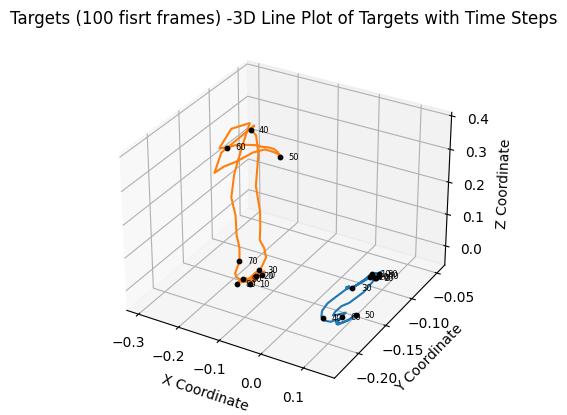

In [16]:
# PLOT MOOVEMENTS OF HAND ON 100 FIRST FRAMES (1 small wave and 1 large wave)
plot_3d_hand_trajectory(targets[:100,:,:], period=10, title='Targets (100 fisrt frames) -')

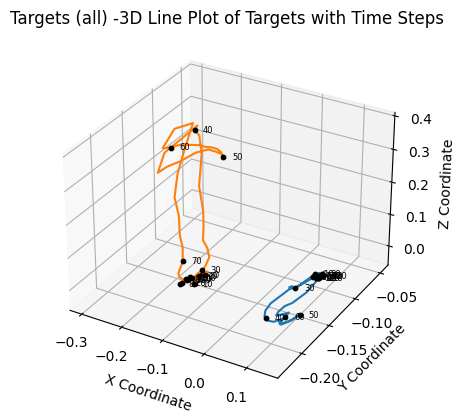

In [17]:
# PLOT MOOVEMENTS OF HAND ON ALL FRAMES (1 small wave and 3 large waves)
plot_3d_hand_trajectory(targets, period=10, title='Targets (all) -')

**2bis/ Alternative preprocessing**
---
Centering on joint 8 (base of neck) instead of joint 0 (hips)<br>
Using reorient_skeleton() function from utils.skeleton which keeps back (joint 0-8) and hips (1-4) straight and centers on plevis



In [18]:
# Choose video file
path = './resources/'
# file = 'mai1.mov'
file = 'anaele_kneel_down.mp4' # anaele_hoolahoop.mp4 anaele_twist.mp4 anaele_kneel_down.mp4
# file = 'output.mp4'
video = path + file

# Extract humain skeleton from video and preprocess
skeletons = blazepose_skeletons(video)

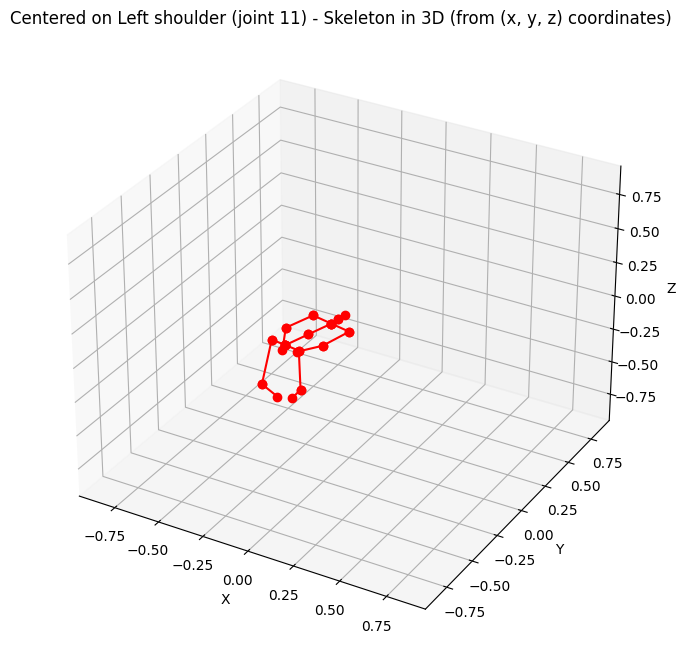

In [19]:
# ALTERNATIVE 1 - CENTERING ON OTHER JOINTS THAN PELVIS (JOINT 0)
# pelvis (ref_joint=0), base of neck (ref_joint=8), left foot (ref_joint=3), left shoulder (ref_joint=11)

# Choose sequence
begin = 100
end = 250
sequence = slice(begin, end)

# RAw skeleton
# plot_skeletons_video_xyz(skeletons[sequence,:,:], topology, proportionnal=1, title="Raw Skeletons") # to viex extract [50:150,:,:]

# Preprocess the skeleton with different centers (ref_joint= 0 pelvis, =3 left foot, =8 base of neck,  =11 left shoulder)
centers = [0, 3, 8, 11]
for center in centers:
    skeletons_pp = preprocess_skeletons(skeletons, topology, ref_joint=center ,alpha= np.pi/4 , smoothing_n=4, interpolation_factor = 1 )
    plot_skeletons_video_xyz(skeletons_pp[sequence,:,:], topology, proportionnal=1, title="Centered on " + joints_name[center] + " (joint "+ str(center) +") - ") # to viex extract [50:150,:,:]

# => CHOICE OF THE CENTERING JOINT TO BE DONE ACCORDING TO POPPY'S EMBODIMENT (joints 0 is fix, joint 8 has little moovement possibilities)

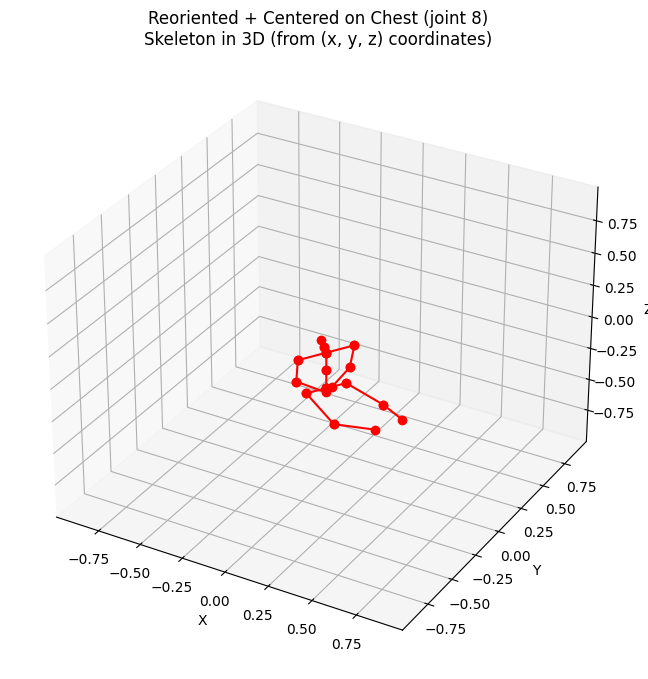

In [22]:
# ALTERNATIVE 2 - HIP AND BACK AUTOMATIC ROTATIONS
# using reorient_skeleton function from utils.skeleton to reorient the skeleton


# Choose sequence
# begin = 100
# end = 250
# sequence = slice(begin, end)

# Centered on joint 0 (pelvis)
skeletons_pp_0 = preprocess_skeletons(skeletons, topology, ref_joint=0 ,alpha= np.pi/4 , smoothing_n=4, interpolation_factor = 1 )
plot_skeletons_video_xyz(skeletons_pp[sequence,:,:], topology, proportionnal=1, title="Preprocessed on joint 0 (pelvis)\n") # to view extract [50:150,:,:]

# Centered + re-oriented
centers = [0, 3, 8]
skeletons_pp = reorder_axes(skeletons)
for center in centers:
    reoriented_skeletons = reorient_skeleton(skeletons_pp, topology)
    reoriented_skeletons = center_skeletons(reoriented_skeletons, ref_joint=center)
    plot_skeletons_video_xyz(reoriented_skeletons[sequence,:,:], topology, proportionnal=1, title="Reoriented + Centered on " + joints_name[center] + " (joint "+ str(center) +")\n") # to view extract [50:150,:,:]

# => DESPITE THE HOOLAHOOPS/TWIST/KNEELING THE BASSIN REMAINS IMMOBILE AND THE BUST ALWAYS STRAIGHT WITH AUTOMATIC REORIENTATION
# => AUTOMATIC REORIENTATION CENTERS ON THE PLEVIS (joint 0) AND STRAIGHTENS THE BUST (joints 0-8 and joints 0-3)
# !!! function may create body distorsions (to be checked) !!!


**3/ GENERATE THE DATASET**
---

In [38]:
# capture several videos

time.sleep(delay) #delay for 2 seconds

# choose parameters
duration = 5    # length of video
delay = 1       # time before video starts
fps = 30        # frame per second
path = './resources/sample_videos/'  # path to save video
format = 'mp4'  # format of video
name = 'sample'

for i in range (3):
    filename= name + "_" + str(i) + "." + format
    take_video(cap, filename=filename, path=path, duration=duration, fps=fps, delay=0)

Camera is open and capturing.
Video captured and saved successfully.
Camera is open and capturing.
Video captured and saved successfully.
Camera is open and capturing.
Video captured and saved successfully.


In [40]:
# Preprocess sample video to poppy skelettons

path_skeletons = './resources/sample_poppy_skeletons/'  # path to save video

for file in os.listdir(path):
    print("processing video:",file)
    skeletons = blazepose_skeletons(path + file)
    skeletons = preprocess_skeletons(skeletons, topology, alpha= np.pi/4 , smoothing_n=4, interpolation_factor = 1 )
    poppy_skeletons = get_poppy_skeletons(skeletons, topology, poppy_lengths)
    torch.save(poppy_skeletons, path_skeletons + file[:-4] + '_poppy_skeletons.pt')

# check the poppy skeletons is preprocessed properly
#plot_skeletons_video_xyz(poppy_skeletons, topology, proportionnal=1, title='Poppy Skeletons - ')

processing video: sample_0.mp4
processing video: sample_1.mp4
processing video: sample_2.mp4
